# Dataset Benchmarking

from jayanta's `/master/experiments/cifar_exp/fte_bte_exp.py`

In [13]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from itertools import product
import pandas as pd

import numpy as np
import pickle

from sklearn.model_selection import StratifiedKFold
from math import log2, ceil 

from joblib import Parallel, delayed
#from multiprocessing import Pool

from proglearn.forest import UncertaintyForest, LifelongClassificationForest

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [19]:
def LF_experiment(train_x, train_y, test_x, test_y, ntrees, ntasks, shift, slot, model, num_points_per_task, test_points_per_task, acorn=None):
       
    df = pd.DataFrame()
    single_task_accuracies = np.zeros(ntasks,dtype=float)
    shifts = []
    tasks = []
    base_tasks = []
    accuracies_across_tasks = []

    for task_ii in range(ntasks):
        print("TASK #", task_ii)
        
        if model == "uf":
            single_task_learner = UncertaintyForest(n_estimators=ntrees*(task_ii+1), max_depth=ceil(log2(num_points_per_task)))

            if acorn is not None:
                np.random.seed(acorn)
                
            single_task_learner.fit(train_x[task_ii][:num_points_per_task],train_y[task_ii][:num_points_per_task])
            llf_task = single_task_learner.predict(test_x[task_ii][:test_points_per_task])
            single_task_accuracies[task_ii] = np.mean(llf_task == test_y[task_ii][:test_points_per_task])

#             single_task_learner.fit(
#                 train_x[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task,:],
#                  train_y[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task] 
#                 )
#             llf_task=single_task_learner.predict(
#                 test_x[task_ii*1000:(task_ii+1)*1000,:]
#                 )
#             single_task_accuracies[task_ii] = np.mean(
#                     llf_task == test_y[task_ii*1000:(task_ii+1)*1000]
#                     )

    lifelong_forest = LifelongClassificationForest(default_n_estimators=ntrees, default_max_depth=ceil(log2(num_points_per_task)))
    for task_ii in range(ntasks):
        print("Starting Task {} For Fold {}".format(task_ii, shift))
        if acorn is not None:
            np.random.seed(acorn)
        
        lifelong_forest.add_task(train_x[task_ii][:num_points_per_task],train_y[task_ii][:num_points_per_task])
#         lifelong_forest.fit(
#             train_x[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task,:], 
#             train_y[task_ii*5000+slot*num_points_per_task:task_ii*5000+(slot+1)*num_points_per_task]
#             )
#         if model == "dnn":
#             llf_task=lifelong_forest.predict(
#                 test_x[task_ii*1000:(task_ii+1)*1000,:], representation=task_ii, decider=task_ii
#                 )
#             single_task_accuracies[task_ii] = np.mean(
#                     llf_task == test_y[task_ii*1000:(task_ii+1)*1000]
#                     )
        
        for task_jj in range(task_ii+1):
            
            llf_task = lifelong_forest.predict(test_x[task_jj][:test_points_per_task], task_id=task_jj)
#             llf_task=lifelong_forest.predict(
#                 test_x[task_jj*1000:(task_jj+1)*1000,:]
#                 )
            
            shifts.append(shift)
            tasks.append(task_jj+1)
            base_tasks.append(task_ii+1)
            
            
            accuracies_across_tasks.append(np.mean(llf_task == test_y[task_jj][:test_points_per_task]))
#             accuracies_across_tasks.append(np.mean(
#                 llf_task == test_y[task_jj*1000:(task_jj+1)*1000]
#                 ))
            
    df['data_fold'] = shifts
    df['task'] = tasks
    df['base_task'] = base_tasks
    df['accuracy'] = accuracies_across_tasks

    df_single_task = pd.DataFrame()
    df_single_task['task'] = range(1, ntasks+1)
    df_single_task['data_fold'] = shift
    df_single_task['accuracy'] = single_task_accuracies
    
    #
    print("single task:\n", single_task_accuracies)
    print("across task:\n", accuracies_across_tasks)
    #

    summary = (df,df_single_task)
    file_to_save = 'result/MNIST/'+model+str(num_points_per_task)+'_'+str(ntrees)+'_'+str(shift)+'_'+str(slot)+'.pickle'
    with open(file_to_save, 'wb') as f:
        pickle.dump(summary, f)

In [10]:
def cross_val_data(data_x, data_y, num_points_per_task, total_task=10, shift=1):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]
    
    batch_per_task=1 #5000//num_points_per_task
    sample_per_class = num_points_per_task//total_task
    test_data_slot=100//batch_per_task

    for task in range(total_task):
        for batch in range(batch_per_task):
            for class_no in range(task*10,(task+1)*10,1):
                #
                print(len(idx))
                print(class_no)
                #
                indx = np.roll(idx[class_no],(shift-1)*100)
                
                if batch==0 and class_no==0 and task==0:
                    print("111")
                    train_x = x[indx[batch*sample_per_class:(batch+1)*sample_per_class],:]
                    train_y = y[indx[batch*sample_per_class:(batch+1)*sample_per_class]]
                    test_x = x[indx[batch*test_data_slot+500:(batch+1)*test_data_slot+500],:]
                    test_y = y[indx[batch*test_data_slot+500:(batch+1)*test_data_slot+500]]
                else:
                    print("222")
                    train_x = np.concatenate((train_x, x[indx[batch*sample_per_class:(batch+1)*sample_per_class],:]), axis=0)
                    train_y = np.concatenate((train_y, y[indx[batch*sample_per_class:(batch+1)*sample_per_class]]), axis=0)
                    test_x = np.concatenate((test_x, x[indx[batch*test_data_slot+500:(batch+1)*test_data_slot+500],:]), axis=0)
                    test_y = np.concatenate((test_y, y[indx[batch*test_data_slot+500:(batch+1)*test_data_slot+500]]), axis=0)
            print("next batch")
        print("next task")
    #
    print("fin cross_val_data")
    #
    return train_x, train_y, test_x, test_y

def sort_data(x_train, y_train, x_test, y_test, num_points_per_task, test_points_per_task, n_tasks=10, shift=1):

    # get data and indices
    unique_labels = np.unique(np.concatenate([y_train,y_test]))
    idx_train = [np.where(y_train == u)[0] for u in unique_labels]
    idx_test = [np.where(y_test == u)[0] for u in unique_labels]
    idx_len = [len(i) for i in idx_train]

    # initialize lists
    train_x_across_task = []
    train_y_across_task = []
    test_x_across_task = []
    test_y_across_task = []

    # calculate amount of samples per task
    labels_per_task = len(unique_labels)//n_tasks
    #print(labels_per_task)
    train_per_class = num_points_per_task//labels_per_task
    #print(train_per_class)
    test_per_class = test_points_per_task
    #print(test_per_class)

    # sort data into batches per class
    for task in range(n_tasks):
        for class_no in range(task*labels_per_task,(task+1)*labels_per_task,1):
            indx_train = np.roll(idx_train[class_no],(shift-1)*n_tasks*labels_per_task)
            indx_test = np.roll(idx_test[class_no],(shift-1)*n_tasks*labels_per_task)
            # if first batch, reset arrays with new data ; otherwise, concatenate arrays
            if class_no == (task*labels_per_task):
                xtr = x_train[indx_train[0:train_per_class],:]
                ytr = y_train[indx_train[0:train_per_class]].flatten()
                xte = x_test[indx_test[0:test_per_class],:]
                yte = y_test[indx_test[0:test_per_class]].flatten()
            else:
                xtr = np.concatenate((xtr, x_train[indx_train[0:train_per_class],:]), axis=0)
                ytr = np.concatenate((ytr, y_train[indx_train[0:train_per_class]].flatten()), axis=0)
                xte = np.concatenate((xte, x_test[indx_test[0:test_per_class],:]), axis=0)
                yte = np.concatenate((yte, y_test[indx_test[0:test_per_class]].flatten()), axis=0)

        # append data to lists
        train_x_across_task.append(xtr)
        train_y_across_task.append(ytr)
        test_x_across_task.append(xte)
        test_y_across_task.append(yte)
        
    return train_x_across_task, train_y_across_task, test_x_across_task, test_y_across_task

In [5]:
def run_parallel_exp(train_x, train_y, test_x, test_y, n_trees, n_tasks, model, num_points_per_task, test_points_per_task, slot=0, shift=1):
    #train_x, train_y, test_x, test_y = cross_val_data(data_x, data_y, num_points_per_task, shift=shift)
    #
    train_x, train_y, test_x, test_y = sort_data(x_train, y_train, x_test, y_test, num_points_per_task, test_points_per_task, n_tasks, shift)
    #
    
#     if model == "dnn":
#         #with tf.device('/gpu:'+str(shift % 4)):
#         #    LF_experiment(train_x, train_y, test_x, test_y, n_trees, shift, model, num_points_per_task, acorn=12345)
#         LF_experiment(train_x, train_y, test_x, test_y, n_trees, n_tasks, shift, slot, model, num_points_per_task, test_points_per_task, acorn=12345)
#     else:
    LF_experiment(train_x, train_y, test_x, test_y, n_trees, n_tasks, shift, slot, model, num_points_per_task, test_points_per_task, acorn=12345)

In [154]:
### MAIN HYPERPARAMS ###
model = "uf"

n_tasks=5
num_points_per_task=10000
test_points_per_task=1000
########################

run with mnist

In [155]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

print(len(np.unique(np.concatenate([y_train,y_test]))))

(60000, 784)
(10000, 784)
(60000,)
(10000,)
10


In [156]:
num_points_per_task = 50
#test_points_per_task= 100

if model == "uf":
    #slot_fold = range(500//num_points_per_task)
    slot_fold = range(1)
    shift_fold = range(1,7,1)
    n_trees=[50]
    iterable = product(n_trees,shift_fold,slot_fold)
    Parallel(n_jobs=-2,verbose=1)(
        delayed(run_parallel_exp)(
                x_train, y_train, x_test, y_test, ntree, n_tasks, model, num_points_per_task, test_points_per_task, slot=slot, shift=shift
                ) for ntree,shift,slot in iterable
                )
# elif model == "dnn":
#     slot_fold = range(5000//num_points_per_task)
#     shift_fold = range(1,7,1)
#     iterable = product(shift_fold,slot_fold)

#     for shift,slot in iterable:
#         run_parallel_exp(data_x, data_y, 0, model, num_points_per_task, slot=slot, shift=shift)

# '''elif model == "dnn":
    
#     def perform_shift(shift):
#         return run_parallel_exp(data_x, data_y, 0, model, num_points_per_task, slot=slot, shift=shift)
    
#     print("Performing Stage 1 Shifts")
#     stage_1_shifts = range(1, 5)
#     with Pool(4) as p:
#         p.map(perform_shift, stage_1_shifts) 
    
#     print("Performing Stage 2 Shifts")
#     stage_2_shifts = range(5, 7)
#     with Pool(4) as p:
#         p.map(perform_shift, stage_2_shifts) '''

TASK # 0


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


TASK # 1
TASK # 2
TASK # 3
TASK # 4
Starting Task 0 For Fold 1
Starting Task 1 For Fold 1
Starting Task 2 For Fold 1
Starting Task 3 For Fold 1
Starting Task 4 For Fold 1
single task:
 [0.994 0.876 0.87  0.874 0.912]
across task:
 [0.994, 0.903, 0.89, 0.977, 0.896, 0.883, 0.984, 0.917, 0.906, 0.957, 0.974, 0.913, 0.921, 0.958, 0.906]
TASK # 0
TASK # 1
TASK # 2
TASK # 3
TASK # 4
Starting Task 0 For Fold 2
Starting Task 1 For Fold 2
Starting Task 2 For Fold 2
Starting Task 3 For Fold 2
Starting Task 4 For Fold 2
single task:
 [0.996 0.926 0.853 0.882 0.832]
across task:
 [0.996, 0.994, 0.929, 0.995, 0.916, 0.87, 0.997, 0.926, 0.874, 0.94, 0.996, 0.898, 0.87, 0.951, 0.851]
TASK # 0
TASK # 1
TASK # 2
TASK # 3
TASK # 4
Starting Task 0 For Fold 3
Starting Task 1 For Fold 3
Starting Task 2 For Fold 3
Starting Task 3 For Fold 3
Starting Task 4 For Fold 3
single task:
 [0.996 0.863 0.876 0.932 0.657]
across task:
 [0.996, 0.988, 0.867, 0.989, 0.893, 0.896, 0.992, 0.901, 0.903, 0.934, 0.993, 0.8

[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:  1.5min finished


from jayanta's `/master/experiments/cifar_exp/plot_one_algo.py`

In [157]:
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import numpy as np
from itertools import product
import seaborn as sns

In [158]:
### MAIN HYPERPARAMS ###
ntrees = 50
slots = 1
shifts = 6
alg_num = 1
task_num = 5
model = "uf"
########################

In [159]:
def calc_mean_bte(btes,task_num=10,reps=6):
    mean_bte = [[] for i in range(task_num)]


    for j in range(task_num):
        tmp = 0
        for i in range(reps):
            tmp += np.array(btes[i][j])
        
        tmp=tmp/reps
        mean_bte[j].extend(tmp)
            
    return mean_bte     

def calc_mean_te(tes,task_num=10,reps=6):
    mean_te = [[] for i in range(task_num)]

    for j in range(task_num):
        tmp = 0
        for i in range(reps):
            tmp += np.array(tes[i][j])
        
        tmp=tmp/reps
        mean_te[j].extend(tmp)
            
    return mean_te 

def calc_mean_fte(ftes,task_num=10,reps=6):
    fte = np.asarray(ftes)
    
    return list(np.mean(np.asarray(fte),axis=0))

def calc_mean_err(err,task_num=10,reps=6):
    mean_err = [[] for i in range(task_num)]


    for j in range(task_num):
        tmp = 0
        for i in range(reps):
            tmp += np.array(err[i][j])
        
        tmp=tmp/reps
        #print(tmp)
        mean_err[j].extend([tmp])
            
    return mean_err 

###################################################################

def get_fte_bte(err, single_err, ntrees):
    bte = [[] for i in range(task_num)]
    te = [[] for i in range(task_num)]
    fte = []
    
    for i in range(task_num):
        for j in range(i,task_num):
            #print(err[j][i],j,i)
            bte[i].append(err[i][i]/err[j][i])
            te[i].append(single_err[i]/err[j][i])
                
    for i in range(task_num):
        #print(single_err[i],err[i][i])
        fte.append(single_err[i]/err[i][i])
            
    return fte,bte,te

```
all_tasks_err: err[j][i] 
cur_tasks_err: single_err[i]
prev_tasks_err: err[i][i]
```

```
te = cur_tasks_err/all_tasks_err
fte = cur_tasks_err/prev_tasks_err
bte = prev_tasks_err/all_tasks_err
```

In [160]:
reps = slots*shifts

btes = [[] for i in range(reps)]
ftes = [[] for i in range(reps)]
tes = [[] for i in range(reps)]
errs_ = [[] for i in range(reps)]

cur_tmp = [[] for _ in range(reps)]
prev_tmp = [[] for _ in range(reps)]
all_tmp = [[] for _ in range(reps)]
err_tmp = [[] for _ in range(reps)]
 
count = 0
for slot in range(slots):
    for shift in range(shifts):
        filename = 'result/MNIST/'+model+str(num_points_per_task)+'_'+str(ntrees)+'_'+str(shift+1)+'_'+str(slot)+'.pickle'
        multitask_df, single_task_df = unpickle(filename)

        err = [[] for _ in range(task_num)]

        for ii in range(task_num):
            err[ii].extend(
             1 - np.array(
                 multitask_df[multitask_df['base_task']==ii+1]['accuracy']
             )
            )
        single_err = 1 - np.array(single_task_df['accuracy'])
        
        ######################
        fte, bte, te = get_fte_bte(err,single_err,ntrees)
        
#         cur_tasks_err = [[] for i in range(task_num)]
#         prev_tasks_err = [[] for i in range(task_num)]
#         all_tasks_err = [[] for i in range(task_num)]
#         for i in range(task_num):
#             cur_tasks_err[i].append(single_err[i])
#             prev_tasks_err[i].append(err[i][i])
            
#             #all_tasks = []
#             for j in range(i,task_num):
#                 all_tasks_err[i].append(err[j][i])
#             #all_tasks_err[i].append(np.mean(all_tasks))
        ######################
    
        err_ = [[] for i in range(task_num)]
        for i in range(task_num):
            for j in range(task_num-i):
                #print(err[i+j][i])
                err_[i].append(err[i+j][i])
        
        btes[count].extend(bte)
        ftes[count].extend(fte)
        tes[count].extend(te)
        errs_[count].extend(err_)
        
#         cur_tmp[count].extend(cur_tasks_err)
#         prev_tmp[count].extend(prev_tasks_err)
#         all_tmp[count].extend(all_tasks_err)
#         err_tmp[count].extend(err_)
        count+=1

In [161]:
# cur_tasks_err_avg = np.mean(np.array(cur_tmp), axis=0).flatten()
# prev_tasks_err_avg = np.mean(np.array(prev_tmp), axis=0).flatten()
# all_tasks_err_avg = np.mean(np.array(all_tmp), axis=0).flatten()

In [162]:
btes

[[[1.0, 0.061855670103092855, 0.2608695652173913, 0.375, 0.23076923076923078],
  [1.0, 1.0576923076923077, 1.3253012048192776, 1.2643678160919543],
  [1.0, 1.24468085106383, 1.4810126582278489],
  [1.0, 1.0238095238095237],
  [1.0]],
 [[1.0, 0.6666666666666666, 0.8, 1.3333333333333333, 1.0],
  [1.0, 0.845238095238095, 0.9594594594594594, 0.6960784313725487],
  [1.0, 1.0317460317460319, 1.0],
  [1.0, 1.2244897959183674],
  [1.0]],
 [[1.0, 0.3333333333333333, 0.36363636363636365, 0.5, 0.5714285714285714],
  [1.0, 1.2429906542056077, 1.3434343434343439, 0.8417721518987341],
  [1.0, 1.0721649484536084, 1.3333333333333337],
  [1.0, 1.099999999999998],
  [1.0]],
 [[1.0, 0.6428571428571429, 0.6428571428571429, 0.5625, 0.5625],
  [1.0, 1.0714285714285714, 1.1320754716981134, 1.3333333333333328],
  [1.0, 1.028268551236749, 1.127906976744186],
  [1.0, 0.8153846153846168],
  [1.0]],
 [[1.0, 1.0, 1.3333333333333333, 2.6666666666666665, 2.0],
  [1.0, 1.15748031496063, 1.3486238532110095, 1.37383177

In [163]:
# te = cur_tasks_err_avg/all_tasks_err_avg
# fte = cur_tasks_err_avg/prev_tasks_err_avg
# bte = prev_tasks_err_avg/all_tasks_err_avg

te = calc_mean_te(tes, task_num=task_num, reps=reps)
bte = calc_mean_bte(btes, task_num=task_num, reps=reps)
fte = calc_mean_fte(ftes, task_num=task_num, reps=reps)
error = calc_mean_err(errs_, task_num=task_num, reps=reps)

In [164]:
bte

[[1.0,
  0.6174521354933726,
  0.663273962244214,
  1.0895833333333333,
  0.9566163003663003],
 [1.0, 1.0796285199993, 1.245421782709761, 1.1540796413366907],
 [1.0, 1.1004990605495069, 1.6841389800042528],
 [1.0, 0.8901927794242548],
 [1.0]]

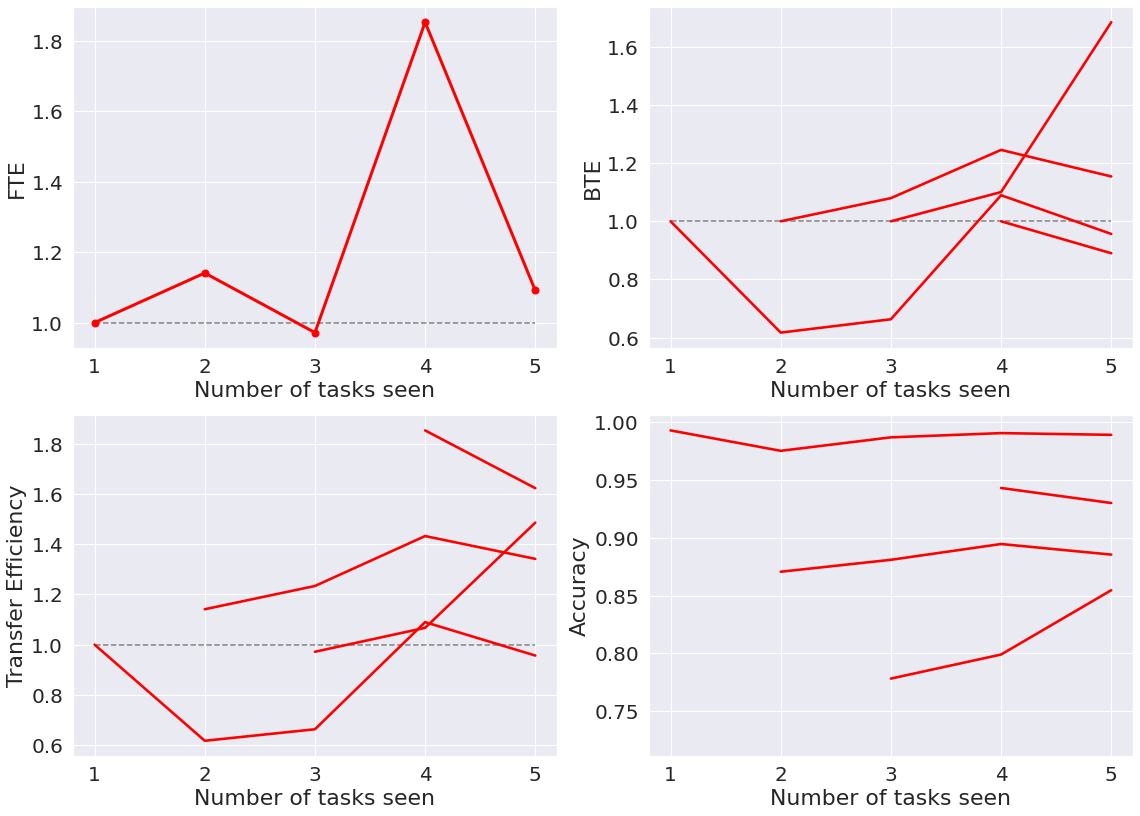

In [165]:
sns.set()

n_tasks=task_num
clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
#c = sns.color_palette(clr, n_colors=len(clr))

fontsize=22
ticksize=20

fig, ax = plt.subplots(2,2, figsize=(16,11.5))
#fig.suptitle('ntrees = '+str(ntrees),fontsize=25)
ax[0][0].plot(np.arange(1,n_tasks+1), fte, c='red', marker='.', markersize=14, linewidth=3)
ax[0][0].hlines(1, 1,n_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][0].set_ylabel('FTE', fontsize=fontsize)


for i in range(n_tasks):

    #et = np.asarray(bte[i])
    et = np.asarray(bte[i]).flatten()

    ns = np.arange(i + 1, n_tasks + 1)
    ax[0][1].plot(ns, et, c='red', linewidth = 2.6)
    
ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][1].set_ylabel('BTE', fontsize=fontsize)
#ax[0][1].set_xticks(np.arange(1,10))
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1,n_tasks, colors='grey', linestyles='dashed',linewidth=1.5)



for i in range(n_tasks):

    #et = np.asarray(te[i])
    et = np.asarray(te[i]).flatten()

    ns = np.arange(i + 1, n_tasks + 1)
    ax[1][0].plot(ns, et, c='red', linewidth = 2.6)
    
ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][0].set_ylabel('Transfer Efficiency', fontsize=fontsize)
#ax[1][0].set_xticks(np.arange(1,10))
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1,n_tasks, colors='grey', linestyles='dashed',linewidth=1.5)

'''for rep in range(reps):
    _, single_task_df = unpickle('./result/'+model+str(ntrees)+'__'+str(rep+1)+'.pickle')
    single_err = 1 - np.array(single_task_df['accuracy'])
   
    for i in range(n_tasks):
        et = np.asarray(err_tmp[rep][i])
        ns = np.arange(i + 1, n_tasks + 1)
        
        ax[1][1].plot(i+1, 1-single_err[i], marker='o',c=c[rep])
        if i==0:
            ax[1][1].plot(ns, 1-et, c=c[rep], label='rep '+str(rep+1) ,linewidth = 2.6)
        else:
            ax[1][1].plot(ns, 1-et, c=c[rep], linewidth = 2.6)
'''

for i in range(n_tasks):
    et = np.asarray(error[i][0])
    ns = np.arange(i + 1, n_tasks + 1)

    ax[1][1].plot(ns, 1-et , c='red', linewidth = 2.6)
            
#ax[1][1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=22)
ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)
#ax[1][1].set_yticks([.4,.6,.8,.9,1, 1.1,1.2])
#ax[1][1].set_xticks(np.arange(1,10))
#ax[1][1].set_ylim(0.89, 1.15)
ax[1][1].tick_params(labelsize=ticksize)

#plt.savefig('./result/figs/fig_trees'+str(ntrees)+"__"+model+'.pdf',dpi=300)